In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model

In [2]:
# m number of data points
# n number of features
m = 500
n = 10

## Homomorphic Encryption

In [3]:
def homomorphic_encryption(X,y):
    # U1 is an orthogonal matrix
    U1 = ortho_group.rvs(dim=X.shape[0])
    
    # U2 is an invertible matrix
    if X.shape[1] > 1:
        U2 = ortho_group.rvs(dim=X.shape[1])
    else:
        U2 = np.random.rand(1,1)
    
    X_enc = U1.dot(X).dot(U2)
    y_enc = U1.dot(y)
    
    return [X_enc,y_enc,U1,U2]

In [4]:
def homomorphic_decryption(X,y,U1,U2):
    
    X_dec = U1.T.dot(X).dot(np.linalg.inv(U2))
    y_dec = U1.T.dot(y)
    
    return [X_dec,y_dec]

## Generate Data

In [5]:
def generate_1d_dataset(m, n, factor=2.0):
    X = np.matrix(np.expand_dims(np.arange(m), 1))
    y = X + np.random.random((m, n)) * factor

    return train_test_split(X, y, test_size=0.5, random_state=42)

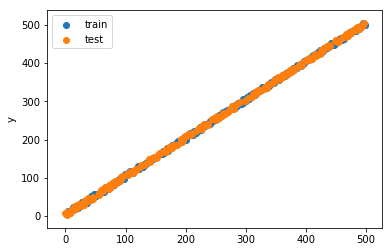

In [6]:
X_train, X_test, y_train, y_test = generate_1d_dataset(m, n, factor=10.0)
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="train")
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Test the Encryption/Decryption Method

In [7]:
H_enc = homomorphic_encryption(X_train,y_train)

In [8]:
H_dec = homomorphic_decryption(H_enc[0],H_enc[1],H_enc[2],H_enc[3])

In [9]:
sum(H_dec[0] - X_train)

matrix([[ -5.27106137e-11]])

In [10]:
sum(H_dec[1] - y_train)

matrix([[ -5.76045878e-11,  -5.41193756e-11,  -4.97273334e-11,
          -5.50193224e-11,  -5.35393951e-11,  -4.92619279e-11,
          -4.83888485e-11,  -5.69588821e-11,  -5.73354697e-11,
          -5.76685366e-11]])

In [11]:
X_enc = H_enc[0]
y_enc = H_enc[1]

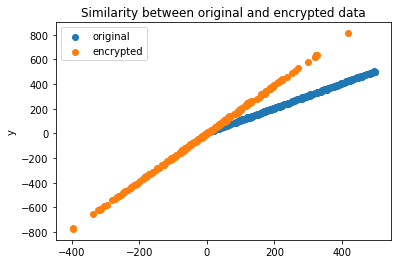

In [12]:
plt.scatter(X_train.T.tolist()[0], y_train.T.tolist()[0], label="original")
plt.scatter(X_enc.T.tolist()[0], y_enc.T.tolist()[0], label="encrypted")
plt.title("Similarity between original and encrypted data")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Train Linear Regression

In [13]:
def estimator_OLS(X,y):
    β̂ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return β̂

### Raw DATA

In [14]:
# Homemade estimator
β̂_raw = estimator_OLS(X_train,y_train)
β̂_raw

matrix([[ 1.01480733,  1.01550519,  1.01537264,  1.01525123,  1.0154638 ,
          1.01428595,  1.01440845,  1.01487773,  1.01457909,  1.01419307]])

In [15]:
# sklearn estimator
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

regr.coef_

array([[ 0.9995548 ],
       [ 1.00000548],
       [ 1.00113166],
       [ 1.00126738],
       [ 0.99680338],
       [ 0.9988939 ],
       [ 0.99905567],
       [ 0.99920334],
       [ 0.99969016],
       [ 0.99752783]])

### Encrypted DATA

In [16]:
# Homemade estimator
β̂_enc = estimator_OLS(X_enc,y_enc)
β̂_enc

matrix([[ 1.94581855,  1.94715664,  1.94690249,  1.94666969,  1.94707729,
          1.94481885,  1.94505372,  1.94595353,  1.94538091,  1.94464074]])

In [17]:
# sklearn estimator
regr_enc = linear_model.LinearRegression()
regr_enc.fit(X_enc, y_enc)

regr_enc.coef_

array([[ 1.94586303],
       [ 1.94713815],
       [ 1.94684296],
       [ 1.94668539],
       [ 1.9470491 ],
       [ 1.94475618],
       [ 1.94509686],
       [ 1.94596118],
       [ 1.94534838],
       [ 1.9445998 ]])

### Compare models

In [18]:
# Homemade estimator
np.sum(H_enc[3].dot(β̂_enc) - β̂_raw)

-2.4424906541753444e-15

In [19]:
# sklearn estimator
np.sum(H_enc[3]*regr_enc.coef_ - regr.coef_)

0.15554236116832665

## Prediction

In [20]:
def predict(β̂,X):
    return X.dot(β̂)

def encrypt_input(X,U2):

    U3 = np.diag(np.random.rand(1,X.shape[0])[0])
    X_enc = U3.dot(X).dot(U2)
    
    return [X_enc,U3]

### Prediction on Encrypted DATA

In [21]:
H = encrypt_input(X_test,H_enc[3])

y_pred_homo = predict(β̂_enc,H[0])
print(f"R2: {r2_score(y_test, y_pred_homo,multioutput='uniform_average')}")

R2: -0.31028801636300657


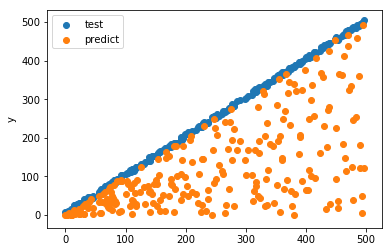

In [22]:
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.scatter(X_test.T.tolist()[0], y_pred_homo.T.tolist()[0], label="predict")
plt.ylabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### Decryption After Prediction

In [23]:
y_pred_homo_dec = np.linalg.inv(H[1]).dot(y_pred_homo)
print(f"R2: {r2_score(y_test, y_pred_homo_dec,multioutput='uniform_average')}")

R2: 0.9993324172356829


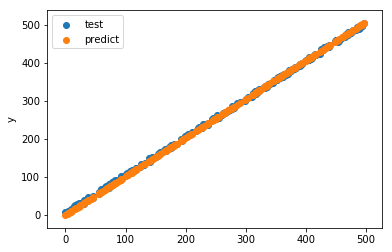

In [24]:
plt.scatter(X_test.T.tolist()[0], y_test.T.tolist()[0], label="test")
plt.scatter(X_test.T.tolist()[0], y_pred_homo_dec.T.tolist()[0], label="predict")
plt.ylabel("X") 
plt.ylabel("y")
plt.legend()
plt.show()